# PRCP-1018-Bike Rental Dataset

## Objectives

**1. Exploratory Data Analysis**  
Thoroughly understand the dataset: quality, distributions, correlations, missing values, and outliers.

**2. Modeling & Interpretation**    
Build accurate, robust model to predict daily bike rentel count based on the environmental and seasonal settings.  
Quantify and explain how features influence the count.

**Metric**: RMSE, MAE, R² Score  
**Dataset**: Bike Rentel Dataset


## Import Libraries

In [21]:
# core libraries
import pandas as pd
import numpy as np
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML Tools
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from scipy.stats.mstats import winsorize

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# saving the model
import joblib

# warnings
import warnings
warnings.filterwarnings("ignore")

# pandas setup
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Reading the Data

In [82]:
day = pd.read_csv(os.path.join('Data','day.csv'))
hour = pd.read_csv(os.path.join('Data','hour.csv'))

There are two dataframes, one with daily bike rentel count and other with hourly bike rentel count. Although, we are trying to predict daily rental count, including aggregated features from hourly dataset can improve the predictive performance of the model.

## Exploratory Data Analysis

In [3]:
print(day.shape)
print(hour.shape)

(731, 16)
(17379, 17)


**The hourly dataset contains 17,379 records instead of the expected 17544 (731 x 24). This indicated 165 missing timestamps. Since, we are using hourly data for feature engineering we have to reconstruct the full hourly timeline.**

In [6]:
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [7]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


**The `instant` column should be dropped as it does not contain meaningful information for modeling. Including it would introduce artificial time trend correlations, reduce model generalization**  
**The columns `casual` and `registered` will be dropped to avoid data leakage, since their sum directly equals the target variable `cnt` and because these values would not be available during real-world inference. However, before dropping these columns we can use them as lag features as the past values are available during real-world inference**  
**Similarly, we have to remove the `dteday` column, but before dropping we can utilize it to extract meaningful calender based features and eventually for merging datasets.**

In [12]:
print(day.info())
print(hour.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns

**We have to do some datatype coversions.**  
**1. convert `dteday` from object to datetime. --> To extract calender time features.**  
**2. convert categorical integer column to category dtype -->
to prevent incorrect assumptions in linear models and to filter out categorical columns using category datatype which in turn can be used to apply appropriate encoding techniques.   
`season`, `yr`, `mnth`, `hr`, `holiday`, `weekday`, `workingday`, `weathersit` These columns are actually categorical but stored as integers.**

**The continous numeric featuers are already in the right datatype (float64), so no need for conversion.**

In [15]:
day.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


In [17]:
hour.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


All feature values lie within the acceptable range. No error values.  
The continous numerical features are already scaled.

### Check for missing values

In [27]:
print(day.isnull().sum().sort_values(ascending=False).head(8))
print(hour.isnull().sum().sort_values(ascending=False).head(8))

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
dtype: int64
instant       0
weathersit    0
registered    0
casual        0
windspeed     0
hum           0
atemp         0
temp          0
dtype: int64


**No missing values found**  
**But we still need to indlude imputation step in pipeline as real-world inference and retraining with new data, will eventually produce missing value.**

In [44]:
cat_cols_d = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
cat_cols_h = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']
print("Value counts of categorical columns in day dataset")
for col in cat_cols_d:
    print(day[col].value_counts())
    print(day[col].nunique())
    print("---------------------------")
print("Value counts of categorical columns in hour dataset")
for col in cat_cols_h:
    print(hour[col].value_counts())
    print(hour[col].nunique())
    print("---------------------------")

Value counts of categorical columns in day dataset
season
3    188
2    184
1    181
4    178
Name: count, dtype: int64
4
---------------------------
yr
1    366
0    365
Name: count, dtype: int64
2
---------------------------
mnth
1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     57
Name: count, dtype: int64
12
---------------------------
holiday
0    710
1     21
Name: count, dtype: int64
2
---------------------------
weekday
6    105
0    105
1    105
2    104
3    104
4    104
5    104
Name: count, dtype: int64
7
---------------------------
workingday
1    500
0    231
Name: count, dtype: int64
2
---------------------------
weathersit
1    463
2    247
3     21
Name: count, dtype: int64
3
---------------------------
Value counts of categorical columns in hour dataset
season
3    4496
2    4409
1    4242
4    4232
Name: count, dtype: int64
4
---------------------------
yr
1    8734
0    8645
Name: count, dtype: int64
2
---------

No error categories found

### Numerical Featuers vs Target

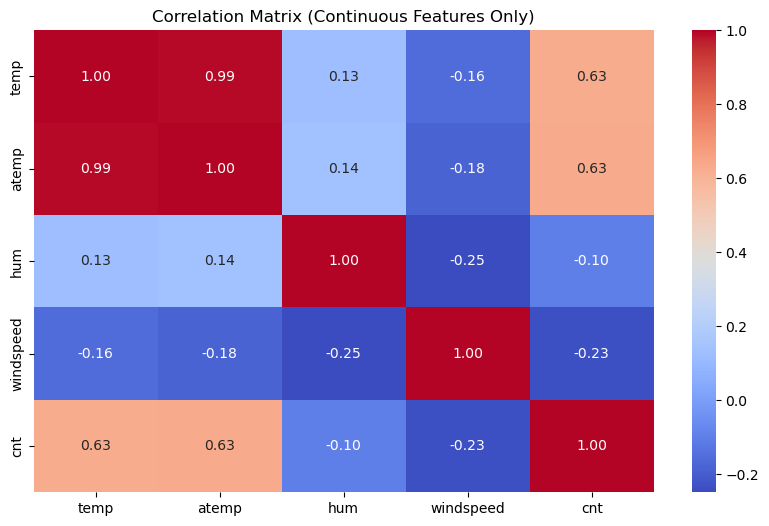

In [4]:
# Select only continuous numerical columns
corr_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

corr = day[corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Continuous Features Only)")
plt.show()

From the above correlation matrix its clear that `temp` and `atemp` are highly correlated and can cause interpretability and performance issues for linear regression. However, we are not relying on coefficients of linear regression for interpretabilty, instead we rely on  SHAP. When it comes to, minor performance downgrade, we can handle this by using other variants like Ridge. Therefore, we are not dropping one of the highly correalted features.

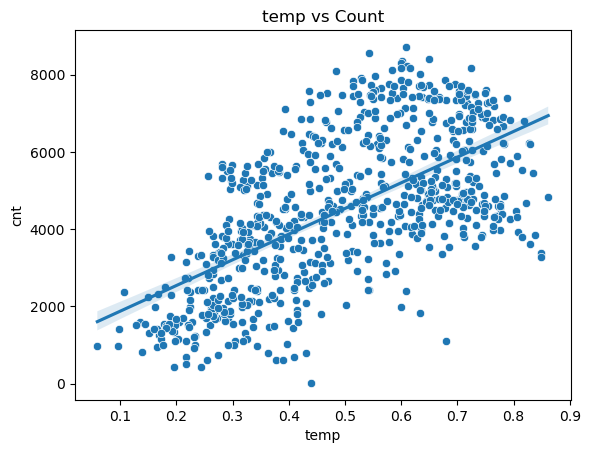

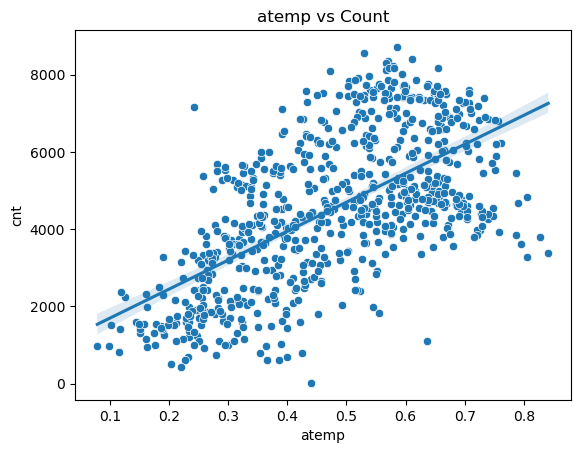

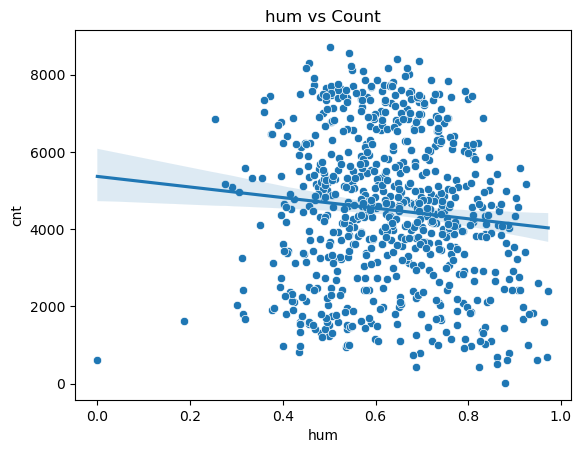

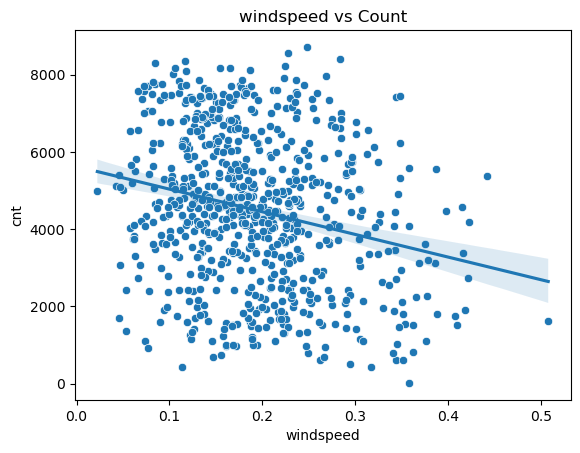

In [49]:
# Scatterplots for top continous numerical features
for col in ['temp', 'atemp', 'hum', 'windspeed']:
    sns.scatterplot(x=day[col], y=day['cnt'])
    sns.regplot(x=day[col], y=day['cnt'], scatter=False, data=day)
    plt.title(f"{col} vs Count")
    plt.show()

Temperature(temp) and Feeling Temperature (atemp) shows strong positive trend. Meanwhile, Humidity and windspeed shows small negative trend.

**During real-time inference, features such as temperature, feel-like temperature, humidity, windspeed and weather situation are retrieved from external weather APIs. So if we want to predict the rentel count of the next day we take forecasted weather informations from external weather APIs.**

### Categories vs Target

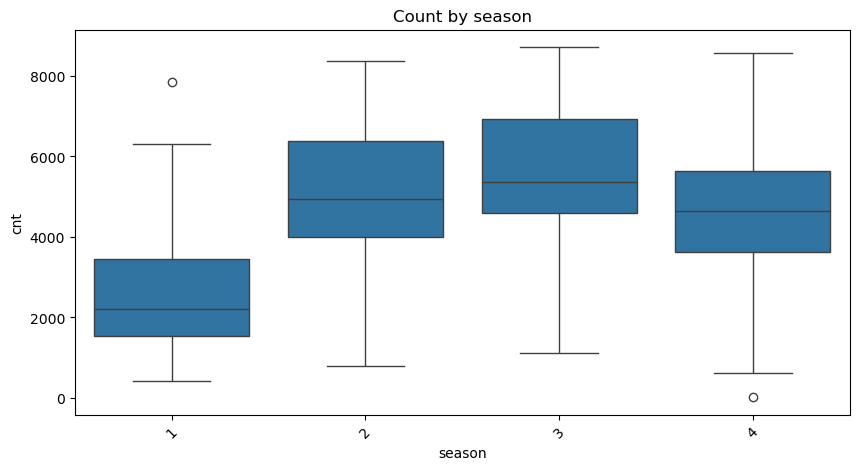

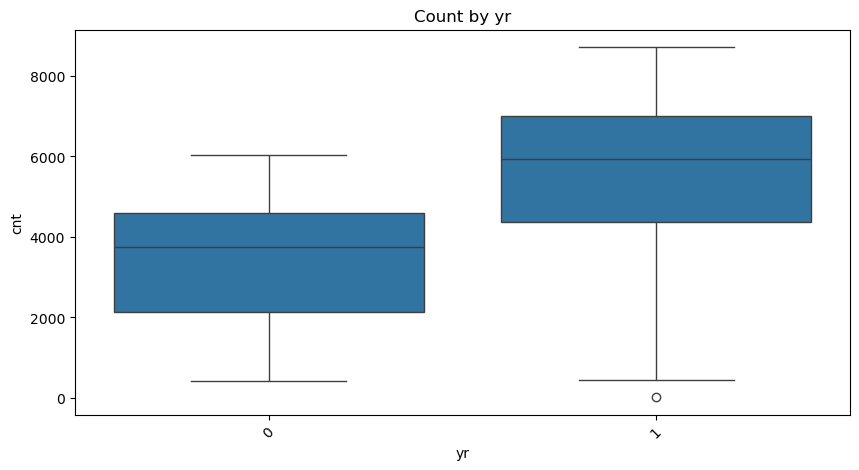

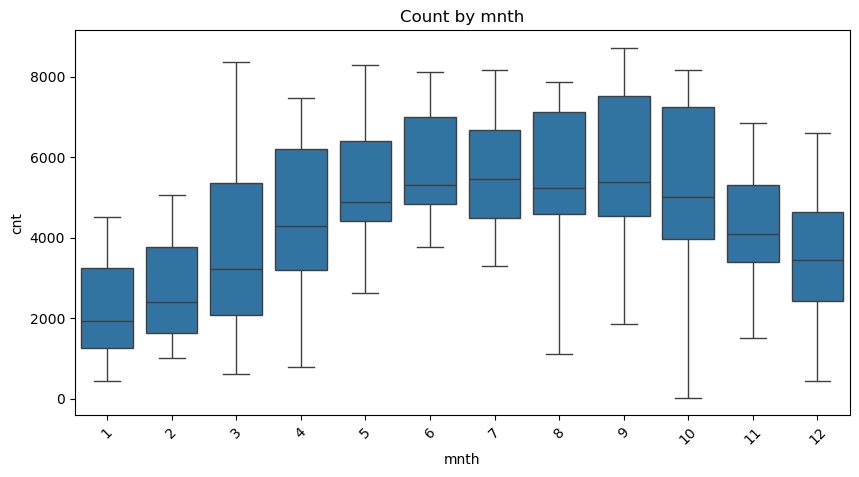

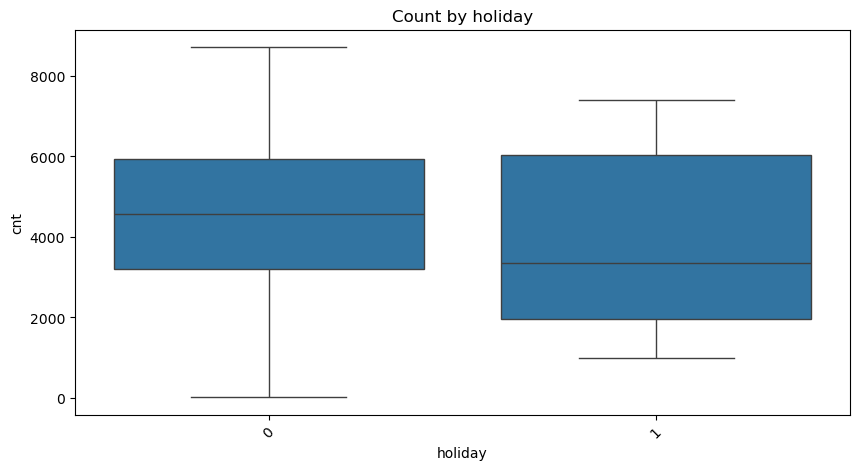

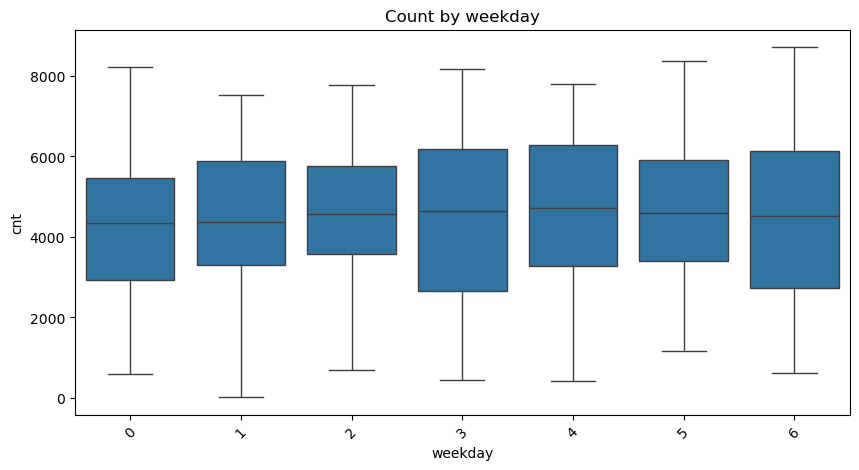

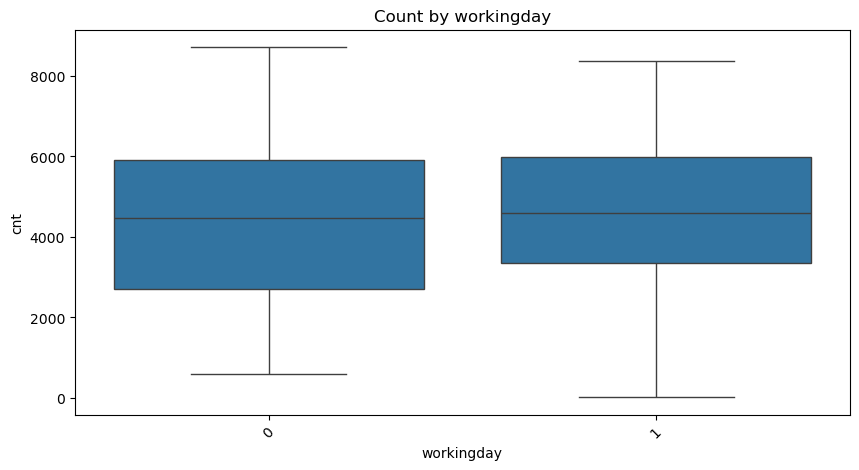

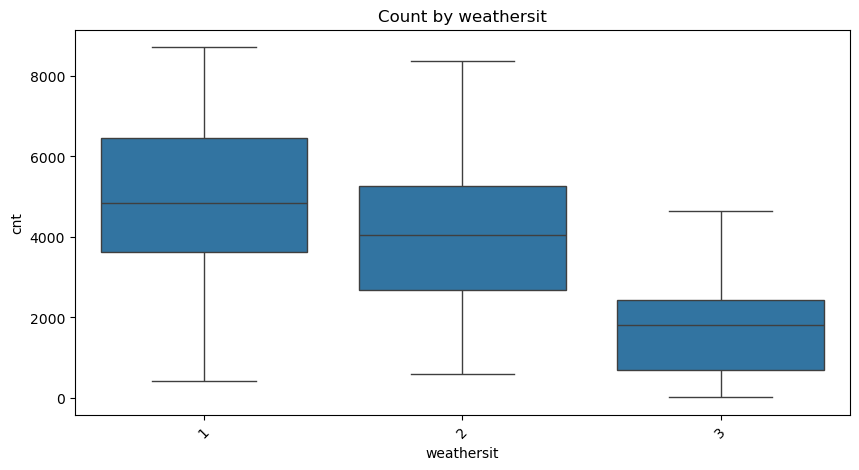

In [54]:
categorical_to_check = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

for col in categorical_to_check:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=col, y='cnt', data=day)
    plt.title(f"Count by {col}")
    plt.xticks(rotation=45)
    plt.show()


The median of count for differnet categories in categorical features like seasons, yr, mnth and weathersit, differ significantly, and therefore these features have great predictive value.

### Target Variable Analysis

Skewness: -0.04735278011900183


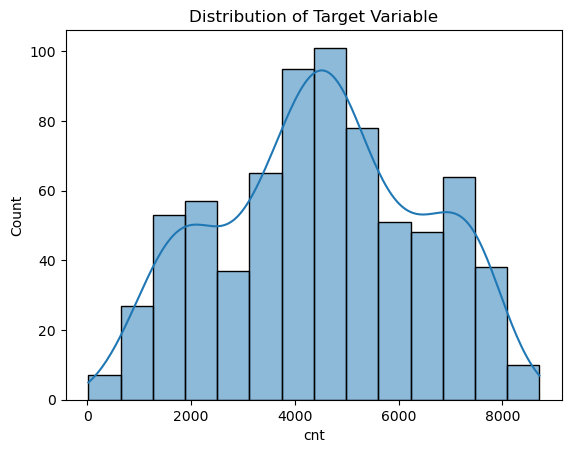

In [55]:
# plotting histogram
sns.histplot(day['cnt'], kde=True)
plt.title("Distribution of Target Variable")
#check skewness
print("Skewness:", day['cnt'].skew())

**The skewness of -0.047 (extremely close to zero) means the distribution is symmetric.  
We do not have a skewness problem here, therefore we dont need to consider transformations like log on target variable.**

Skewness of temp: -0.054520964760408276
Skewness of atemp: -0.13108804205446
Skewness of hum: -0.06978343399095213
Skewness of windspeed: 0.6773454211095378


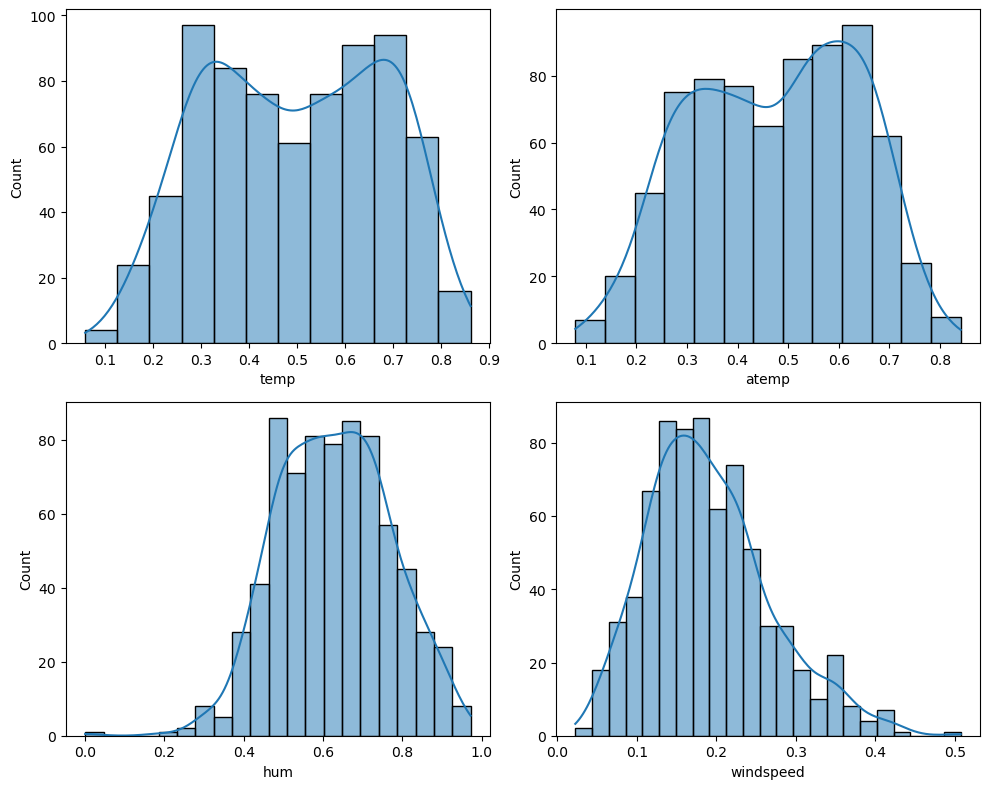

In [14]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

sns.histplot(day['temp'], kde=True, ax=ax[0,0])
print("Skewness of temp:", day['temp'].skew())

sns.histplot(day['atemp'], kde=True, ax=ax[0,1])
print("Skewness of atemp:", day['atemp'].skew())

sns.histplot(day['hum'], kde=True, ax=ax[1,0])
print("Skewness of hum:", day['hum'].skew())

sns.histplot(day['windspeed'], kde=True, ax=ax[1,1])
print("Skewness of windspeed:", day['windspeed'].skew())

plt.tight_layout()


**The fetures temp, atemp, hum has very slight skew, so no transformation is needed.  
Whereas, windspeed exhibit moderate right skew, therefore we might need right scaling technique to reduce skew.(to align with the assumptions of linear models).  
However, these are not the only numerical columns we have to deal with, after feature engineering we will have a lot more numerical column waiting to be scaled appropriately based on skew and winsorized if outlier are present**

## Time series analysis

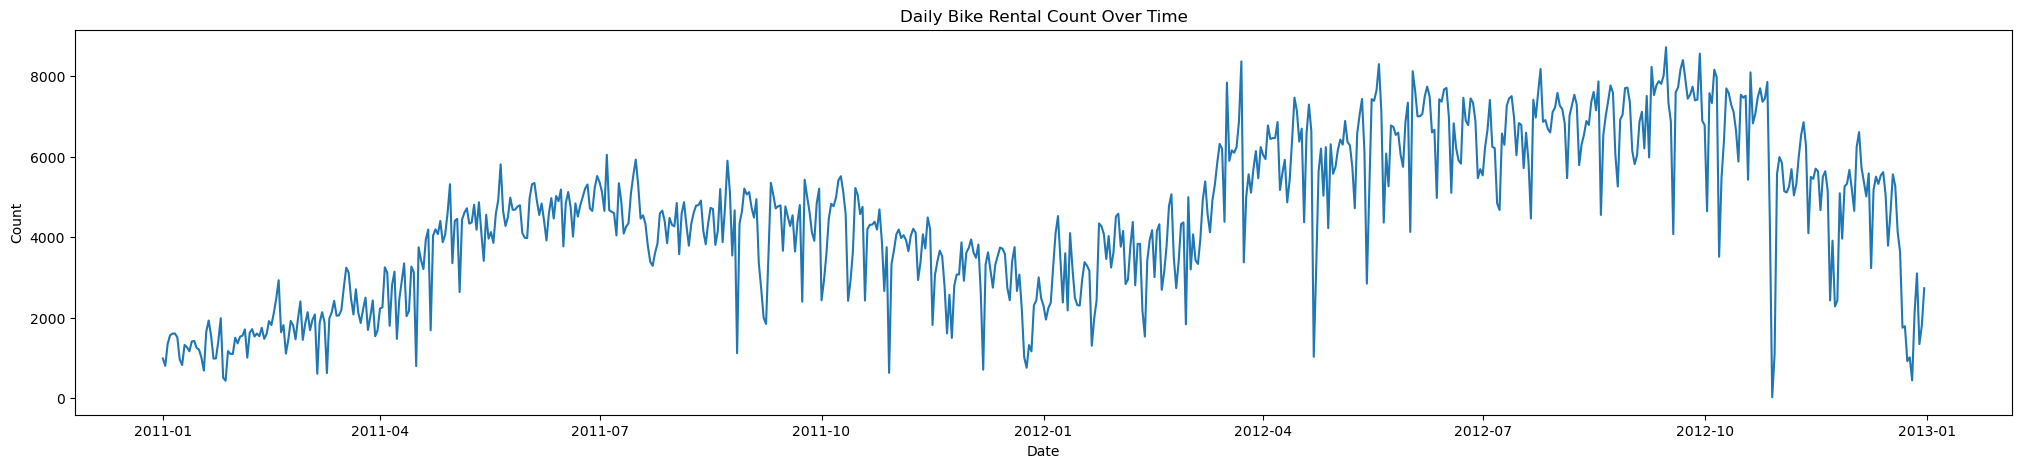

In [3]:
day['dteday'] = pd.to_datetime(day['dteday'])
plt.figure(figsize=(25,5))
sns.lineplot(data=day, x='dteday', y='cnt')
plt.title("Daily Bike Rental Count Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

Key insights from plot:
1. Clear seasonal patterns:  
    rentals increases significantly during warmer months.  
    rentals decrease during colder months.    
    this confirms that seasons and weather feautures are highly important predictors.    
2. Year-over-Year Growth:    
    the overall trend shows 2012 has consistently higher rentel counts thatn 2011.  
    this suggest increasing popularity of bike-sharing program, making the target variable non-stationary.
3. High volatility on some days:    
   this indicates the dataset may contain anomalies or event-driven fluctuations.  
4. No large gaps:    
   confirms that the daily dataset is complete.
   
**The above insights like seasonality and yearly growth suggests us to create more time-based features (lag, rolling etc from past datapoints) apart from the ones which we already have.  
Classical time series models like ARIMA, SARIMA etc, are unsuitable for bike rental forecasting because the daily rental count has strong dependece on exogenous weather features which the classical time-series models cannot capture.**

________________________________________________________________________________________________________________________________

________________________________________________________________________________________________________________________________

# Feature Engineering

## Prepare the Daily Dataset

####  Dropping `instant` Column

In [3]:
day = day.drop(columns=['instant'])

#### Changing Datatypes

In [4]:
day['dteday'] = pd.to_datetime(day['dteday']) # to extract date realted features

In [5]:
cat_cols = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
day[cat_cols] = day[cat_cols].astype('category') # changing datatype of categorical columns for proper encoding

#### Sort by date

In [6]:
day = day.sort_values('dteday')

#### Create Lag Features

In [7]:
day['cnt_lag_1'] = day['cnt'].shift(1)   # cnt from previous day
day['cnt_lag_2'] = day['cnt'].shift(2)   # cnt from the day before yesterday
day['cnt_lag_7'] = day['cnt'].shift(7)   # same weekday last week

In [8]:
day['casual_lag_1'] = day['casual'].shift(1)   # casual count from previous day
day['casual_lag_2'] = day['casual'].shift(2)   # casual count from the day before yesterday
day['registered_lag_1'] = day['registered'].shift(1)   # registered count from previous day
day['registered_lag_2'] = day['registered'].shift(2)   # registered count from the day before yesterday

#### Create Rolling window features

In [9]:
# shift important to prevent data leakage
# mean of last n counts
day['cnt_rolling_3'] = day['cnt'].shift(1).rolling(3).mean() 
day['cnt_rolling_7'] = day['cnt'].shift(1).rolling(7).mean()
day['cnt_rolling_14'] = day['cnt'].shift(1).rolling(14).mean()

In [10]:
day['casual_rolling_7'] = day['casual'].shift(1).rolling(7).mean()
day['registered_rolling_7'] = day['registered'].shift(1).rolling(7).mean()

In [11]:
# variance window
day['cnt_rolling_7_var'] = day['cnt'].shift(1).rolling(7).var()

#### Create Weather smoothing features

In [12]:
day['temp_3d_avg'] = day['temp'].shift(1).rolling(3).mean()
day['hum_3d_avg'] = day['hum'].shift(1).rolling(3).mean()
day['wind_3d_avg'] = day['windspeed'].shift(1).rolling(3).mean()

#### Create Calender Time Features

In [13]:
day['is_weekend'] = day['weekday'].isin([0,6]).astype(int) # weekend indicator
day['is_month_end'] = day['dteday'].dt.is_month_end.astype(int) # end of month indicator
day['is_month_start'] = day['dteday'].dt.is_month_start.astype(int) # start of month indicator

####  Dropping `casual` and `registered` Column

In [16]:
day = day.drop(columns=['casual','registered']) # to prevent data leakage

#### Dropping rows with missing values

inclusion of lag features gave rise to missing values and that has to be removed

In [21]:
day = day.dropna().reset_index(drop=True)

#### Saving the progress

In [26]:
day.to_csv("day_df.csv", index=False)

________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________

## Prepare the Hourly dataset

####  Dropping `instant` Column

In [3]:
hour = hour.drop(columns=['instant'])

#### Changing Datatypes

In [4]:
hour['dteday'] = pd.to_datetime(hour['dteday']) 

#### creating a new datetime column

In [5]:
hour['datetime'] = hour['dteday'] + pd.to_timedelta(hour['hr'], unit='h')

#### sort and set as index 

In [6]:
hour = hour.sort_values('datetime').set_index('datetime') # sorting with datetime and making it as index

#### Create the full index - remember the missing timesteps

In [7]:
full_index = pd.date_range(start=hour.index.min(), end=hour.index.max(), freq='H')

#### Make the full index as the new index

In [8]:
hour = hour.reindex(full_index)

#### Updation of index has created missing values in the missing timesteps.

In [9]:
hour.isnull().sum()

dteday        165
season        165
yr            165
mnth          165
hr            165
holiday       165
weekday       165
workingday    165
weathersit    165
temp          165
atemp         165
hum           165
windspeed     165
casual        165
registered    165
cnt           165
dtype: int64

165 records have to be imputed

#### Imputing date and hour

In [10]:
hour['dteday'] = hour.index.date # dteday imputed from index
hour['hr'] = hour.index.hour     # hour imputed from index

#### Adding the missing flag column

In [11]:
hour['missing_flag'] = hour['cnt'].isna().astype(int) #to tell the model that these records were artificially filled

#### Fill missing time steps

In [12]:
hour[['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']] = \
    hour[['temp','atemp','hum','windspeed','casual','registered','cnt']].interpolate(method='time') # interpolating only the relevant columns

For time dependent numerical features time interpolation is a fair method to impute

In [13]:
hour['weathersit'] = hour['weathersit'].ffill().bfill()

Weather condition often stay consistent for many hours.  
So, for weather based categorical column forwardfill is a good choice for imputing and for beginning timesteps where forward fill is not possible backward fill can be utilised.

#### Creating new dataframe by grouping and aggreagting based on date

In [14]:
# group by date
grp = hour.groupby('dteday')

def get_peak_hour(x):
    return x.idxmax().hour if x.notna().any() else np.nan

def get_min_hour(x):
    return x.idxmin().hour if x.notna().any() else np.nan

def segment_sum(x, start_hour, end_hour):
    mask = (x.index.hour >= start_hour) & (x.index.hour <= end_hour)
    return x.loc[mask, 'cnt'].sum()

hour_info_df = pd.DataFrame({
    # ----- COUNTS -----
    'yesterday_cnt_max': grp['cnt'].max(),
    'yesterday_cnt_min': grp['cnt'].min(),
    'yesterday_cnt_var': grp['cnt'].var(),

    'yesterday_cnt_max_hour': grp['cnt'].apply(get_peak_hour),
    'yesterday_cnt_min_hour': grp['cnt'].apply(get_min_hour),

    # ----- CASUAL -----
    'yesterday_casual_max': grp['casual'].max(),
    'yesterday_casual_min': grp['casual'].min(),
    'yesterday_casual_var': grp['casual'].var(),

    'yesterday_casual_max_hour': grp['casual'].apply(get_peak_hour),
    'yesterday_casual_min_hour': grp['casual'].apply(get_min_hour),

    # ----- REGISTERED -----
    'yesterday_registered_max': grp['registered'].max(),
    'yesterday_registered_min': grp['registered'].min(),
    'yesterday_registered_var': grp['registered'].var(),

    'yesterday_registered_max_hour': grp['registered'].apply(get_peak_hour),
    'yesterday_registered_min_hour': grp['registered'].apply(get_min_hour),

    # ----- WEATHER -----
    'yesterday_temp_max': grp['temp'].max(),
    'yesterday_temp_min': grp['temp'].min(),
    'yesterday_temp_var': grp['temp'].var(),

    'yesterday_temp_max_hour': grp['temp'].apply(get_peak_hour),
    'yesterday_temp_min_hour': grp['temp'].apply(get_min_hour),

    'yesterday_atemp_max': grp['atemp'].max(),
    'yesterday_atemp_min': grp['atemp'].min(),
    'yesterday_atemp_var': grp['atemp'].var(),

    'yesterday_hum_max': grp['hum'].max(),
    'yesterday_hum_min': grp['hum'].min(),
    'yesterday_hum_var': grp['hum'].var(),

    'yesterday_windspeed_max': grp['windspeed'].max(),
    'yesterday_windspeed_min': grp['windspeed'].min(),
    'yesterday_windspeed_var': grp['windspeed'].var(),

    # weather hours
    'yesterday_atemp_max_hour': grp['atemp'].apply(get_peak_hour),
    'yesterday_atemp_min_hour': grp['atemp'].apply(get_min_hour),
    'yesterday_hum_max_hour': grp['hum'].apply(get_peak_hour),
    'yesterday_hum_min_hour': grp['hum'].apply(get_min_hour),
    'yesterday_windspeed_max_hour': grp['windspeed'].apply(get_peak_hour),
    'yesterday_windspeed_min_hour': grp['windspeed'].apply(get_min_hour),

    # missing hours present
    'did_yesterday_have_missing_hour':  grp['missing_flag'].max(),
    
    # segmented counts
    'yesterday_morning_cnt': grp.apply(lambda x: segment_sum(x, 6, 11)),
    'yesterday_afternoon_cnt': grp.apply(lambda x: segment_sum(x, 12, 17)),
    'yesterday_evening_cnt': grp.apply(lambda x: segment_sum(x, 18, 23)),
})


All the column names we have suggest that we have yesterday's stat but we have to shift 1 step down to make it actually the stats of yesterday's.

#### Shifting the dataset

In [15]:
hour_info_df = hour_info_df.shift(1) # to prevent data leakage

Shifting creates a row with missing values in the beginning, it has to be dropped.

In [16]:
hour_info_df = hour_info_df.dropna() # for dropping the first row (all NaN values)

#### Create a new column with the current index values.

In [17]:
hour_info_df = hour_info_df.reset_index() # for merging later

#### Saving the progress

In [19]:
hour_info_df.to_csv("hour_info_df.csv", index=False)

________________________________________________________________________________________________________________________________

________________________________________________________________________________________________________________________________

### Merging the daily and hourly datase grouped (date) and aggregated

In [4]:
day_df = pd.read_csv('day_df.csv')
hour_info_df = pd.read_csv('hour_info_df.csv')

In [5]:
df = pd.merge(day_df, hour_info_df, on='dteday', how='left')

In [6]:
df = df.drop(columns=['dteday'])

In [8]:
df.to_csv("final_data.csv", index=False)

________________________________________________________________________________________________________________________________

________________________________________________________________________________________________________________________________

## Modelling

In [2]:
df = pd.read_csv('final_data.csv') # reading the final dataset
df.shape

(717, 70)

### Features and target

In [3]:
X = df.drop('cnt', axis=1)
y = df['cnt']
print(X.shape)
print(y.shape)

(717, 69)
(717,)


### Train-Test split

**We should use a time-based split for bike-rental regression because future demand must be predicted only from past data, and a random split would leak “future information” into training and give unrealistically high scores.**

In [4]:
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(573, 69)
(144, 69)
(573,)
(144,)


### categorizing columns

In [7]:
categorical_cols = [
    'season',
    'yr',
    'mnth',
    'holiday',
    'weekday',
    'workingday',
    'weathersit',
    'is_weekend',
    'is_month_start',
    'is_month_end',
    'did_yesterday_have_missing_hour'
]

categorical columns will be one hot encoded

In [8]:
numerical_cols = [
    'temp', 'atemp', 'hum', 'windspeed',
    'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_7',
    'casual_lag_1', 'casual_lag_2',
    'registered_lag_1', 'registered_lag_2',
    'cnt_rolling_3', 'cnt_rolling_7', 'cnt_rolling_14',
    'casual_rolling_7', 'registered_rolling_7',
    'cnt_rolling_7_var',
    'temp_3d_avg', 'hum_3d_avg', 'wind_3d_avg',

    'yesterday_cnt_max', 'yesterday_cnt_min', 'yesterday_cnt_var',
    'yesterday_cnt_max_hour', 'yesterday_cnt_min_hour',

    'yesterday_casual_max', 'yesterday_casual_min', 'yesterday_casual_var',
    'yesterday_casual_max_hour', 'yesterday_casual_min_hour',

    'yesterday_registered_max', 'yesterday_registered_min', 'yesterday_registered_var',
    'yesterday_registered_max_hour', 'yesterday_registered_min_hour',

    'yesterday_temp_max', 'yesterday_temp_min', 'yesterday_temp_var',
    'yesterday_temp_max_hour', 'yesterday_temp_min_hour',

    'yesterday_atemp_max', 'yesterday_atemp_min', 'yesterday_atemp_var',
    'yesterday_atemp_max_hour', 'yesterday_atemp_min_hour',

    'yesterday_hum_max', 'yesterday_hum_min', 'yesterday_hum_var',
    'yesterday_hum_max_hour', 'yesterday_hum_min_hour',

    'yesterday_windspeed_max', 'yesterday_windspeed_min', 'yesterday_windspeed_var',
    'yesterday_windspeed_max_hour', 'yesterday_windspeed_min_hour',

    'yesterday_morning_cnt', 'yesterday_afternoon_cnt', 'yesterday_evening_cnt'
]

The numerical columns may contain columns with outliers and high skewness. These properties determines the right scaling technique and whether to use winsorization or not , So they have to splitted further based on the presence of outlier and skewness.

In [9]:
len(categorical_cols)+len(numerical_cols) # making sure all the columns are included

69

### Selecting columns to winsorize based on outlier presence

In [10]:
winsor_cols = []
non_winsor_cols = []

for col in numerical_cols:
    series = df[col].dropna()

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1 # interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_ratio = ((series < lower_bound) | (series > upper_bound)).mean()

    # If < 1% of values are extreme → winsorize
    if outlier_ratio < 0.01:
        winsor_cols.append(col)
    else:
        non_winsor_cols.append(col)


print("WINSORIZE these columns:", winsor_cols)
print("\nDo NOT winsorize these columns:", non_winsor_cols)

WINSORIZE these columns: ['temp', 'atemp', 'hum', 'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_7', 'registered_lag_1', 'registered_lag_2', 'cnt_rolling_3', 'cnt_rolling_7', 'cnt_rolling_14', 'casual_rolling_7', 'registered_rolling_7', 'temp_3d_avg', 'hum_3d_avg', 'yesterday_cnt_max', 'yesterday_cnt_var', 'yesterday_cnt_max_hour', 'yesterday_casual_min_hour', 'yesterday_registered_max', 'yesterday_registered_max_hour', 'yesterday_temp_max', 'yesterday_temp_min', 'yesterday_atemp_max', 'yesterday_atemp_min', 'yesterday_windspeed_max_hour', 'yesterday_windspeed_min_hour', 'yesterday_morning_cnt', 'yesterday_evening_cnt']

Do NOT winsorize these columns: ['windspeed', 'casual_lag_1', 'casual_lag_2', 'cnt_rolling_7_var', 'wind_3d_avg', 'yesterday_cnt_min', 'yesterday_cnt_min_hour', 'yesterday_casual_max', 'yesterday_casual_min', 'yesterday_casual_var', 'yesterday_casual_max_hour', 'yesterday_registered_min', 'yesterday_registered_var', 'yesterday_registered_min_hour', 'yesterday_temp_var', 'yesterday

Winsorization alone can reduce skewness to an extend to which we may have to select standard scaler over robest scaler for some columns, therefore check skewness after winsorization to select scaling technique.

#### Winsorized dataset before checking skewness

In [11]:
df_temp = df.copy()

for col in winsor_cols:
    lower = df_temp[col].quantile(0.01)
    upper = df_temp[col].quantile(0.99)
    df_temp[col] = df_temp[col].clip(lower, upper)

#### Selecting columns for standard scaling and robest sclaing based on skew

In [12]:
standard_scaler_cols = []
robust_scaler_cols = []

for col in numerical_cols:
    skew_val = df_temp[col].skew()

    if abs(skew_val) > 0.75:
        robust_scaler_cols.append(col)
    else:
        standard_scaler_cols.append(col)


In [13]:
print("Columns to Winsorize:")
print(winsor_cols)

print("Columns to Scale with StandardScaler:")
print(standard_scaler_cols)

print("Columns to Scale with RobustScaler:")
print(robust_scaler_cols)

Columns to Winsorize:
['temp', 'atemp', 'hum', 'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_7', 'registered_lag_1', 'registered_lag_2', 'cnt_rolling_3', 'cnt_rolling_7', 'cnt_rolling_14', 'casual_rolling_7', 'registered_rolling_7', 'temp_3d_avg', 'hum_3d_avg', 'yesterday_cnt_max', 'yesterday_cnt_var', 'yesterday_cnt_max_hour', 'yesterday_casual_min_hour', 'yesterday_registered_max', 'yesterday_registered_max_hour', 'yesterday_temp_max', 'yesterday_temp_min', 'yesterday_atemp_max', 'yesterday_atemp_min', 'yesterday_windspeed_max_hour', 'yesterday_windspeed_min_hour', 'yesterday_morning_cnt', 'yesterday_evening_cnt']
Columns to Scale with StandardScaler:
['temp', 'atemp', 'hum', 'windspeed', 'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_7', 'registered_lag_1', 'registered_lag_2', 'cnt_rolling_3', 'cnt_rolling_7', 'cnt_rolling_14', 'casual_rolling_7', 'registered_rolling_7', 'temp_3d_avg', 'hum_3d_avg', 'wind_3d_avg', 'yesterday_cnt_max', 'yesterday_cnt_var', 'yesterday_casual_min_hour', 'yesterday_registered

In [14]:
len(standard_scaler_cols)+len(robust_scaler_cols)+len(categorical_cols)

69

#### Defining models to compare

In [22]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5),
    'DecisionTree': DecisionTreeRegressor(max_depth=8, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    'LightGBM':LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=-1, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
}

#### DataFrameWrapper 
Dataframewrapper used because we have multiple column transformers and it outputs numpy arrays, so each time using it results in loosing dataframe columns. Therefore, we need dataframe wrapper to preserve column names.

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)


#### Winsorizer function inside Function transformer

In [24]:
#winsorizer function
def winsorize_array(X, lower_limit=0.01, upper_limit=0.01):
    X = np.asarray(X, dtype=float)
    out = np.empty_like(X)
    for j in range(X.shape[1]):
        out[:, j] = winsorize(X[:, j], limits=(lower_limit, upper_limit)).data
    return out
    
# instantiating function transformer
winsor_transformer = FunctionTransformer(winsorize_array, validate=False)

### Complete preprocessor pipeline

In [25]:
# IMPUTATION 
# median over mean for nunmeric column because many column exhibit skewness

impute_step = Pipeline(steps=[
    ("impute", ColumnTransformer(
        transformers=[
            ("num_impute", SimpleImputer(strategy="median"), numerical_cols),
            ("cat_impute", SimpleImputer(strategy="most_frequent"), categorical_cols),
        ],
        remainder="passthrough"
    )),
    ("to_df", DataFrameWrapper(columns=numerical_cols + categorical_cols))
])

# WINSORIZATION 

winsor_step = Pipeline(steps=[
    ("winsor", ColumnTransformer(
        transformers=[
            ("winsor", winsor_transformer, winsor_cols)
        ],
        remainder="passthrough"
    )),
    ("to_df", DataFrameWrapper(columns=numerical_cols + categorical_cols))
])

# SCALING 

scale_onehot_step = ColumnTransformer(
    transformers=[
        ("std", StandardScaler(), standard_scaler_cols),
        ("rob", RobustScaler(), robust_scaler_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="drop"
)

# FULL PREPROCESSOR

preprocessor = Pipeline(steps=[
    ("impute", impute_step),       # Imputation
    ("winsor", winsor_step),       # Winsorization
    ("scale_encode", scale_onehot_step)   # Scaling + Encoding
])


________________________________________________________________________________________________________________________________

________________________________________________________________________________________________________________________________

### Train and Evaluate models

In [26]:
results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)
print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6856
[LightGBM] [Info] Number of data points in the train set: 573, number of used features: 91
[LightGBM] [Info] Start training from score 4240.886562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

### Model Comparison

In [27]:
results_df

,Model,RMSE,R2
1,Ridge,812.800868,0.813449
3,ElasticNet,813.995800,0.812900
2,Lasso,817.431508,0.811318
0,LinearRegression,819.536824,0.810345
6,GradientBoosting,887.926954,0.777370
8,LightGBM,926.657020,0.757525
7,XGBoost,1016.892750,0.708003
5,RandomForest,1072.088084,0.675444
4,DecisionTree,1364.384185,0.474344


**The linear models outperformed tree-based ensemble models.**  
**The top 3 models `Ridge`, `ElasticNet` and `Lasso` is selected for further hyperparameter tuning**

### Hyperparameter Tuning of Ridge

In [100]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

In [99]:
ridge_param_grid = {
    'model__alpha': [
        1e-5, 1e-4, 1e-3, 1e-2, 1e-1,
        1, 5, 10, 20, 50, 100, 200, 500, 1000
    ],
    'model__fit_intercept': [True, False],
    'model__solver': [
        'auto', 'svd', 'cholesky', 'lsqr',
        'sparse_cg', 'sag', 'saga', 'lbfgs'
    ],
    'model__tol': [1e-4, 1e-3, 1e-2],
    'model__max_iter': [None, 1000, 5000, 10000]
}

In [101]:
from sklearn.model_selection import GridSearchCV

ridge_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=ridge_param_grid,
    scoring='r2',
    cv = TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    verbose=3
)

ridge_grid_search.fit(X_train, y_train)

print("Best Params:", ridge_grid_search.best_params_)
print("Best CV Score:", ridge_grid_search.best_score_)


Fitting 5 folds for each of 2688 candidates, totalling 13440 fits
Best Params: {'model__alpha': 1, 'model__fit_intercept': True, 'model__max_iter': None, 'model__solver': 'sparse_cg', 'model__tol': 0.01}
Best CV Score: 0.1189286717604062


In [102]:
best_model = ridge_grid_search.best_estimator_

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 834.60
Test R²: 0.8033


### Hyperparameter Tuning of ElasticNet

In [90]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',  ElasticNet())
])

In [91]:
elastic_param_grid = {
    'model__alpha': [
        1e-4, 3e-4, 1e-3, 3e-3,
        0.01, 0.03, 0.1, 0.3,
        1, 3, 5
    ],
    
    'model__l1_ratio': [
        0.0, 0.1, 0.2, 0.3, 0.4,
        0.5, 0.6, 0.7, 0.8, 0.9, 1.0
    ],
    
    'model__max_iter': [5000, 10000, 20000],
    'model__tol': [1e-4, 1e-3],

    
    'model__selection': ['cyclic', 'random']
}

In [92]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
from sklearn.model_selection import GridSearchCV

elastic_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=elastic_param_grid,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    verbose=3
)

elastic_grid.fit(X_train, y_train)

print("Best Params:", elastic_grid.best_params_)
print("Best CV Score:", elastic_grid.best_score_)


Fitting 5 folds for each of 1452 candidates, totalling 7260 fits
Best Params: {'model__alpha': 5, 'model__l1_ratio': 1.0, 'model__max_iter': 20000, 'model__selection': 'random', 'model__tol': 0.001}
Best CV Score: 0.18581445876803362


In [94]:
best_model = elastic_grid.best_estimator_

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 848.26
Test R²: 0.7968


### Hyperparameter Tuning of Lasso

In [95]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

In [96]:
lasso_param_grid = {
    'model__alpha': [
        1e-5, 3e-5, 1e-4, 3e-4,
        1e-3, 3e-3, 1e-2, 3e-2,
        0.1, 0.3, 1, 3, 10
    ],

    'model__max_iter': [5000, 10000, 20000],

    'model__tol': [1e-5, 1e-4, 1e-3],

    'model__selection': ['cyclic', 'random']
}

In [97]:
lasso_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=lasso_param_grid,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    verbose=3
)

lasso_grid.fit(X_train, y_train)

print("Best Params:", lasso_grid.best_params_)
print("Best CV R²:", lasso_grid.best_score_)


Fitting 5 folds for each of 234 candidates, totalling 1170 fits
Best Params: {'model__alpha': 10, 'model__max_iter': 5000, 'model__selection': 'cyclic', 'model__tol': 0.001}
Best CV R²: 0.18131171195599907


In [98]:
best_model = lasso_grid.best_estimator_

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 874.32
Test R²: 0.7841


**None of the models achieved higher R2 score after hyperparameter tuning, Therefore, the Ridge model is being selected as final model based on its initial performance with default parameters.**

________________________________________________________________________________________________________________________________

________________________________________________________________________________________________________________________________

### Final Model - Ridge

In [104]:
pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Ridge(alpha=1.0))
    ])

In [105]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [116]:
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.2f}")

Test RMSE: 812.80
Test R²: 0.8134
Test MAE: 570.88


**On average, your model's error is around ±813 bikes per day, with more weight given to large mistakes (because RMSE penalizes big errors).  
The model explains 81.34% of the variance in daily bike rentals.  
The average absolute error is about ±571 bikes per day, It means most predictions are off by 500–600 bikes.**

### Save the model

In [108]:
joblib.dump(pipe, 'Best_Pipe_Ridge.pkl')

['Best_Pipe_Ridge.pkl']

### Plotting Actual vs Predicted Bike Rentals

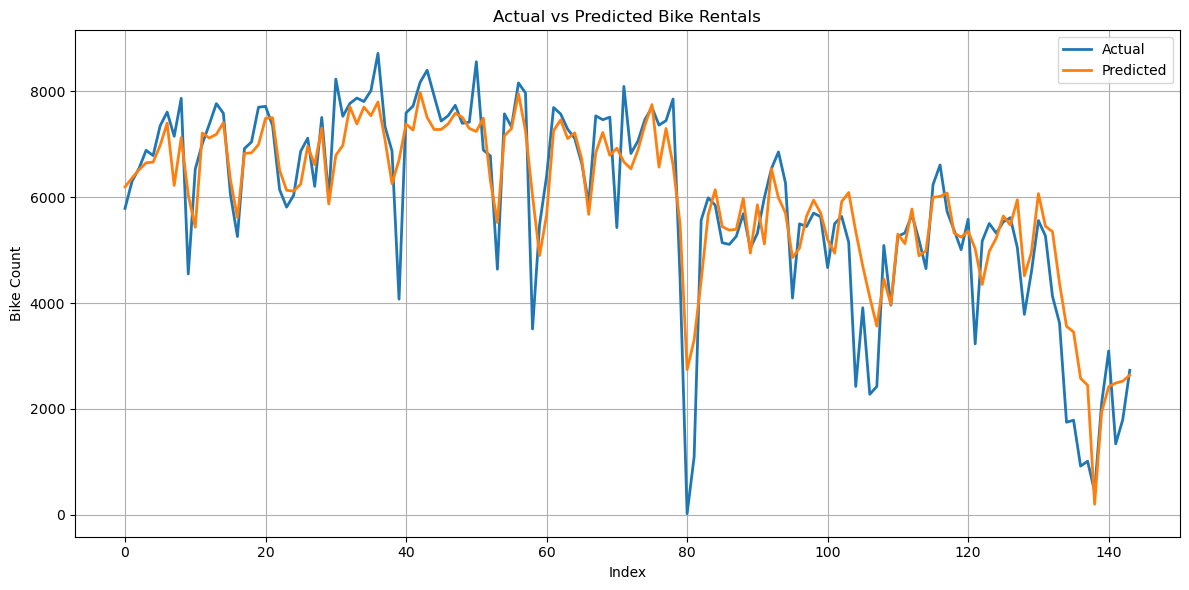

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)

plt.xlabel('Index')
plt.ylabel('Bike Count')
plt.title('Actual vs Predicted Bike Rentals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**The predictions follow the overall pattern very closely, only missing some extreme peaks and drops**

### Extracting Feature importance from Ridge by Permutaion Importance  
Permutation importance quantifies how much the model's predictive performance drops when the values of a single feature are randomly shuffled.  
So if shuffling a feature causes a big drop in model preformance, that feature is important.

In [117]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipe, X_test, y_test, n_repeats=100, random_state=42)
perm_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)
perm_importance.head(15)

,Feature,Importance
40,yesterday_registered_max,0.303628
11,cnt_lag_1,0.231034
7,temp,0.127058
8,atemp,0.087557
14,casual_lag_1,0.077881
6,weathersit,0.068063
37,yesterday_casual_var,0.067003
9,hum,0.060577
22,registered_rolling_7,0.045567
10,windspeed,0.027547


## Insights

`yesterday_registered_max` the hourly max count of registered count yesterday, dominates demand. Registered users are stable, habitual riders. Their demand naturally carries over from yesterday.  

`cnt_lag_1`, Yesterday’s total demand is the second most important signal. Confirms that lag-based features are crucial for this dataset.  

Temperature (`temp` and `atemp`) is the most important weather feature. Higher temperature leads to more rides.  

`casual_lag_1`, High casual rides yesterday, more likely today too.    

`weathersit`and`hum`, shows weather effects are realistically captured.  

________________________________________________________________________________________________________________________________

________________________________________________________________________________________________________________________________

### Challenges Faced

1. The dataset had a large number of numerical, categorical, lag, rolling-window, and engineered features — all needing different preprocessing.  
Built a modular, multi-stage scikit-learn pipeline that handled:  
Imputation  
Winsorization (only for some numeric columns)  
Appropriate scaling (StandardScaler / RobustScaler)  
One-Hot Encoding for categorical columns

3. Identifying skewed, normal, and outlier-heavy columns   
Solution:    
automated:  
Skewness detection (numerical_cols_normal vs numerical_cols_skewed)  
Outlier detection for Winsorization  
A 3-way splitter for numeric columns  
This allowed correct scaling strategy per column.

 
5. Winsorization inside a scikit-learn pipeline    
scikit-learn has no built-in Winsorizer, so you needed a custom step that still worked with ColumnTransformer and preserved DataFrame structure.  
Build a custom FunctionTransformer + DataFrameWrapper, inserted it after imputation, and ensured scaling happened after winsorization.


7. Time-based splitting vs random splitting  
Random train-test split gave inflated R² because future rows leaked into training.
Switched to a proper time-based split, accepting the drop in R² but gaining a realistic, leakage-free evaluation.


9. Tried SHAP but failed to implement  
SHAP couldn't extract feature names due to the custom DataFrameWrapper, causing errors.
Switched to Permutation Importance, which works directly on the final trained model, avoiding need for internal pipeline names.


11. Missing Timesteps in the Hourly Dataset  
Recreated the complete timestep and imputed using interpolation technique.


13. Utilising only the daily dataset in it raw from can lead to poor performace.  
Therefore, heavy feature engineering was carried out, by including information from the past timesteps in the form of lag and rolling features, from both the daily and hourly dataset.

### Note

**Even with a proper time-based split, the R² score may still appear slightly inflated because the model is trained on actual future weather values, whereas real-world forecasting would rely on external weather APIs that provide imperfect and noisy predictions sometimes. However, we cannot remove future weather features and rely solely on lagged weather variables, because doing so significantly reduces model performance.**

### Future Work

1. Integrate Real Weather Forecast APIs    
Evaluate model robustness under realistic weather uncertainty.   
2. Experiment with Neural Models  
Evaluate sequence-based models like RNNs and LSTMs. These could capture deeper temporal relationships between engineered features.
3. Deploy the Model  
The model can be deployed through a REST API, scheduled batch pipeline, or cloud-hosted service that consumes weather forecasts and outputs daily demand predictions.  
4. Create better features

________________________________________________________________________________________________________________________________

________________________________________________________________________________________________________________________________